# All states

- For nut(2): 
    - nut on table
        - (peg in hole)
    - nut in jig

- For bolt(4): 
    - bolt on table
        - (peg in hole)
    - bolt in jig
        - (screw)
    - bolt in nut
        - (pick_and_place)
    - bolt in bin
 
 ## This includes less states. But trajectories of actions might be needed. 

# All states

- For nut(4): 
    - nut on table
        - pick
    - nut picked up
        - move
    - nut over jig
        - peg
    - nut in jig

- For bolt(10): 
    - bolt on table
        - pick
    - bolt picked up
        - move
    - bolt over bolt hole 1
        - peg
    - bolt in jig
        - pick
    - bolt over bolt hole 2
        - move
    - bolt over nut hole 1
        - screw
    - bolt in nut
        - pick
    - bolt over nut hole 2
        - move
    - bolt over bin
        - place
    - bolt in bin
   
 ## This is more discrete. Less action prior needed. Harder to cluster due to more states. More huristics needed(eg. pick things up to some amount of hight). Suitable for first step.

In [38]:
%matplotlib notebook

# Load data
from torch import nn
import torch.nn.functional as F
import numpy as np
import torch
from torch.utils.data import DataLoader

x_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')


input_dim = x_train.shape[1] # data dimension
output_dim = 10 # number of states

# Make them tensors
x_train = torch.from_numpy(x_train).view(-1,input_dim).float()
y_train = torch.from_numpy(y_train).view(-1,1)

bolt_picked = x_train[:5,] + torch.FloatTensor([0, 0.1, 0])
bolt_over_bolt_hole_1 = x_train[5:10,] + torch.FloatTensor([0, 0.05, 0])
bolt_over_bolt_hole_2 = x_train[5:10,] + torch.FloatTensor([0, 0.1, 0])
bolt_over_nut_hole_1 = x_train[10:,] + torch.FloatTensor([0, 0.05, 0])
bolt_over_nut_hole_2 = x_train[10:,] + torch.FloatTensor([0, 0.1, 0])
bolt_in_bin = x_train[:5,] + torch.FloatTensor([0.3 + np.random.random(), 0.03, 0.3 + np.random.random()])
bolt_over_bin = bolt_in_bin + torch.FloatTensor([0, 0.1, 0])

x_train = torch.cat((x_train, bolt_picked, bolt_over_bolt_hole_1, bolt_over_bolt_hole_2, bolt_over_nut_hole_1,
                    bolt_over_nut_hole_2, bolt_over_bin, bolt_in_bin))
for i in range(7):
    x = i + 3
    temp = torch.ones(5, dtype = int) * x
    temp = temp.view(5, -1)
    y_train = torch.cat((y_train, temp))

<IPython.core.display.Javascript object>


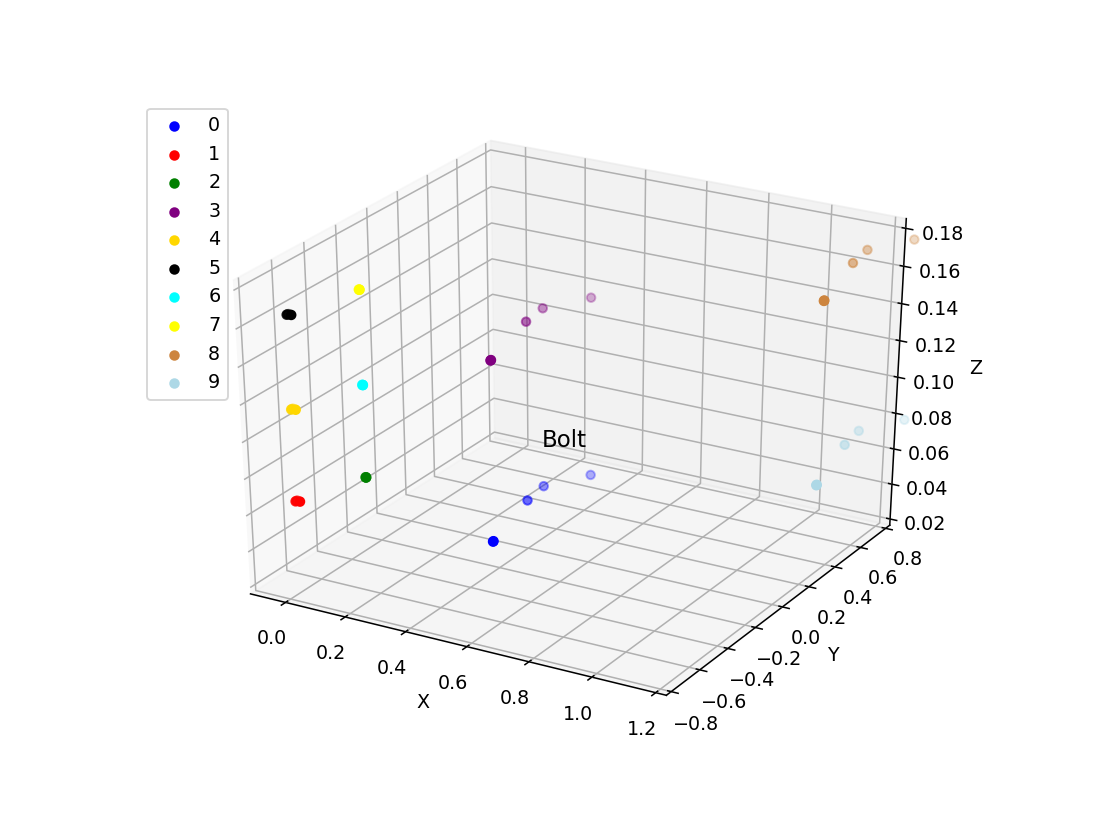

In [47]:
from mpl_toolkits import mplot3d
from matplotlib import pyplot as plt

fig = plt.figure(1, (8,6))
ax = fig.add_subplot(1, 1, 1, projection='3d')
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
colors = ['blue', 'red', 'green', 'purple', 'gold', 'black', 'cyan', 'yellow', 'peru', 'lightblue']

for label in labels:
    indices = np.nonzero(y_train.flatten() == label)
    samples = x_train[indices,:].squeeze()
    if samples.ndim ==1:
        x_points = samples[0]
        y_points = samples[1]
        z_points = samples[2]
    else:
        x_points = samples[:,0]
        y_points = samples[:,1]
        z_points = samples[:,2]
    ax.scatter3D(x_points,z_points, y_points, c = colors[label], label='{}'.format(labels[label]))
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_ylim([-0.8,0.8])
    ax.set_zlabel('Z')
    plt.title('Bolt')
    plt.legend(loc = 'best')

In [48]:
from scipy.stats import trim_mean
from sklearn.covariance import MinCovDet

def build_model(estimated_labels, data_concat):
    models = []
    # model the distribution of each cluster robustly in case there are misclassifications
    for label in np.unique(estimated_labels):
        indices = np.nonzero(estimated_labels == label)
        samples = data_concat[indices,:].squeeze()
        if samples.ndim == 1:
            means = samples
            covariance = np.zeros((3,3))
        else:
            means = trim_mean(samples, 0, axis=0)
            mcd = MinCovDet(support_fraction=1).fit(samples)
            covariance = mcd.covariance_
        models.append([means, covariance, label - min(estimated_labels)])
    return models

In [49]:
import pickle

models = build_model(y_train.flatten(), x_train)
with open('../states_model/models_bolt_10', 'wb') as f:
    pickle.dump(models, f)
    

C:\Users\xyao0\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:644: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "
C:\Users\xyao0\Anaconda3\lib\site-packages\torch\storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [92]:
variance_coefficient = 5
x_val = []
y_val = []
for model in models:
    x_val.append(np.random.multivariate_normal(model[0][:3] , model[1][:3,:3] * variance_coefficient , n_samples))
    y_val += [model[2]] * n_samples 

x_val = torch.FloatTensor(x_val).view(-1, 3)
y_val = torch.LongTensor(y_val)

In [50]:
# Define the network structure

class MyNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, output_dim)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x


In [89]:
def train(x_train, y_train, net, criterion, USE_GPU = True):
    n = x_train.shape[0]
    dim = x_train.shape[1]
    ind = torch.randperm(n)
    x_train = x_train[ind]
    y_train = y_train[ind]
    if USE_GPU:
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        net = net.cuda()
    for i in ind:
        x = x_train[i].view(-1, dim)
        y = y_train[i]
        net.zero_grad()
        output = net(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
    return loss
    

def validate(x_val, y_val, net, criterion):
    val_loss = 0
    n = x_val.shape[0]
    with torch.no_grad():
        for i in range(n):
            x = x_val[i].view(-1, input_dim)
            y = torch.unsqueeze(y_val[i], 0)
            output = net(x)
            val_loss += criterion(output, y)    
        val_loss = val_loss / n
    return val_loss            

<IPython.core.display.Javascript object>


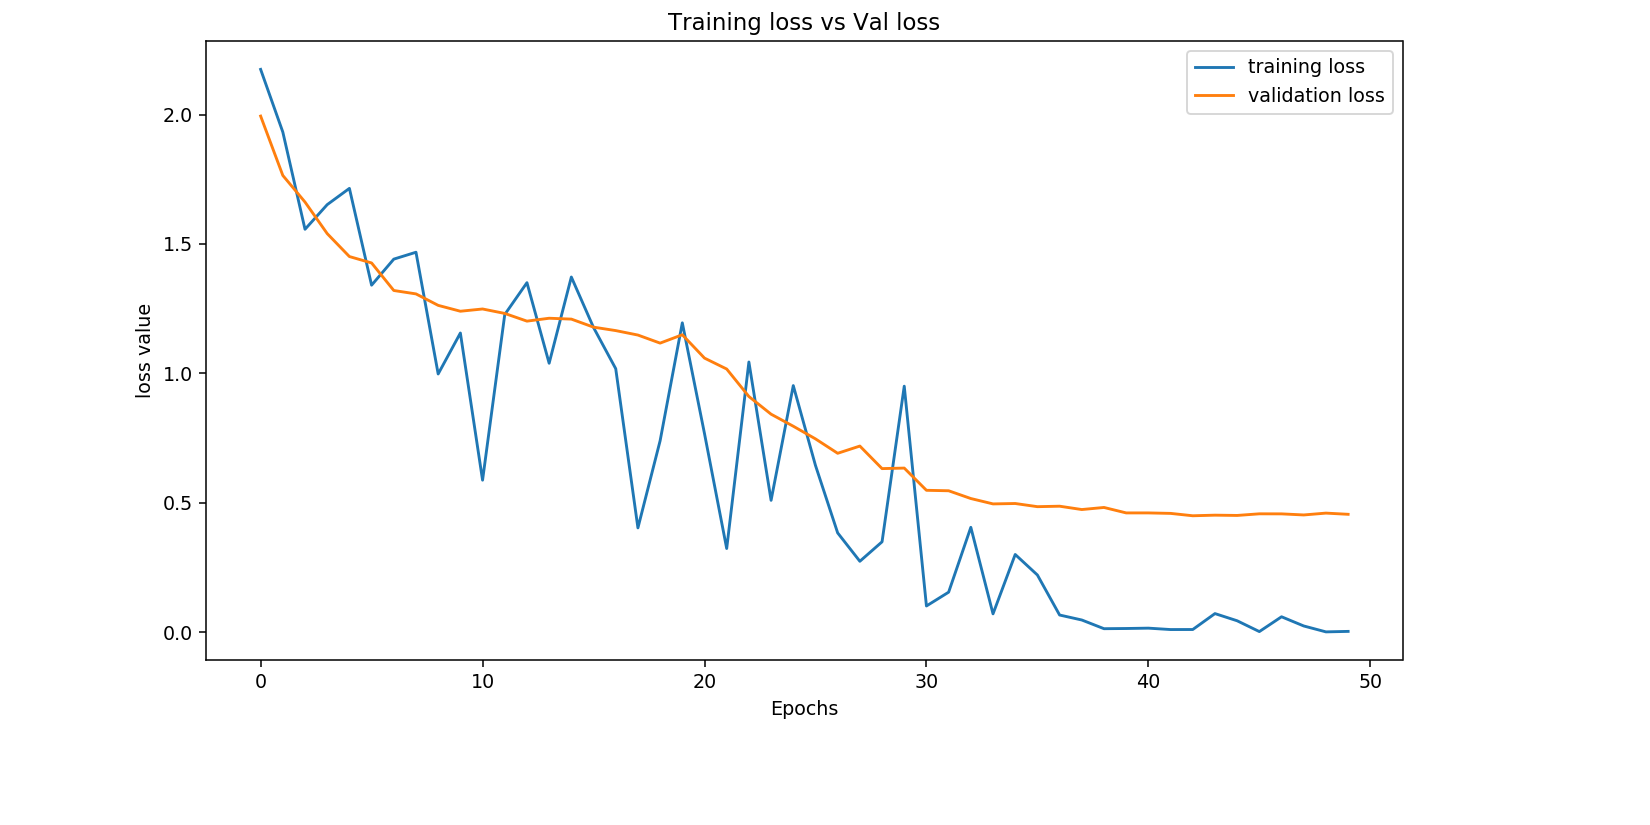

Epoch: 0 Loss: 2.1742382049560547
Epoch: 1 Loss: 1.932284951210022
Epoch: 2 Loss: 1.5568164587020874
Epoch: 3 Loss: 1.6519713401794434
Epoch: 4 Loss: 1.714730978012085
Epoch: 5 Loss: 1.3410017490386963
Epoch: 6 Loss: 1.441603183746338
Epoch: 7 Loss: 1.4681775569915771
Epoch: 8 Loss: 0.9981940984725952
Epoch: 9 Loss: 1.156280279159546
Epoch: 10 Loss: 0.5881624221801758
Epoch: 11 Loss: 1.227748990058899
Epoch: 12 Loss: 1.3506836891174316
Epoch: 13 Loss: 1.0395567417144775
Epoch: 14 Loss: 1.372471809387207
Epoch: 15 Loss: 1.1775615215301514
Epoch: 16 Loss: 1.0185582637786865
Epoch: 17 Loss: 0.4038808345794678
Epoch: 18 Loss: 0.7403087615966797
Epoch: 19 Loss: 1.1955864429473877
Epoch: 20 Loss: 0.7678653001785278
Epoch: 21 Loss: 0.3242412805557251
Epoch: 22 Loss: 1.044403314590454
Epoch: 23 Loss: 0.5102715492248535
Epoch: 24 Loss: 0.9533095359802246
Epoch: 25 Loss: 0.645050048828125
Epoch: 26 Loss: 0.38457727432250977
Epoch: 27 Loss: 0.27497339248657227
Epoch: 28 Loss: 0.35015249252319336


In [94]:
import torch.optim as optim

net = MyNet(input_dim, output_dim)
optimizer = optim.Adam(net.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

epoches = 50

train_loss_list = []
val_loss_list = []

fig = plt.figure(2, figsize=(12,6))
plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
ax = fig.add_subplot(1,1,1)

for e in range(epoches):
    train_loss = train(x_train, y_train, net.train(), criterion)
    train_loss_list.append(train_loss)
    val_loss = validate(x_val.cuda(), y_val.cuda(), net.eval(), criterion)
    val_loss_list.append(val_loss)
    ax.clear()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('loss value')
    ax.set_title('Training loss vs Val loss')
    ax.plot(train_loss_list, label='training loss')
    ax.plot(val_loss_list, label='validation loss')
    ax.legend(loc='upper right')
    fig.canvas.draw()
    print("Epoch: {} Loss: {}".format(e, train_loss))

In [53]:
def predict(x, net):
    with torch.no_grad():
        output = net(x)
        return torch.argmax(output)

def test(x_test, y_test, net, USE_GPU = True):
    n = x_test.shape[0]
    predictions = torch.zeros(n).long()
    if USE_GPU:
        x_test = x_test.cuda()
        net = net.cuda()
    with torch.no_grad():
        for i in range(n):
            prediction = predict(x_test[i,:], net)
            predictions[i] = prediction
    accuracy = int(sum(predictions.detach() == y_test)) / n 
    return predictions, accuracy

In [95]:
n_test = 1000
accuracy = 0
for i in range(n_test):
    variance_coefficient = 5
    n_samples = 10
    samples_bolt = []
    x_test = []
    y_test = []
    for model in models:
        x_test.append(np.random.multivariate_normal(model[0][:3] , model[1][:3,:3] * variance_coefficient , n_samples))
        y_test += [model[2]] * n_samples 

    x_test = torch.FloatTensor(x_test).view(-1, 3)
    y_test = torch.FloatTensor(y_test)
    a, b = test(x_test, y_test, net)1
    accuracy += b
print(accuracy / n_test)

0.9686600000000136


<IPython.core.display.Javascript object>


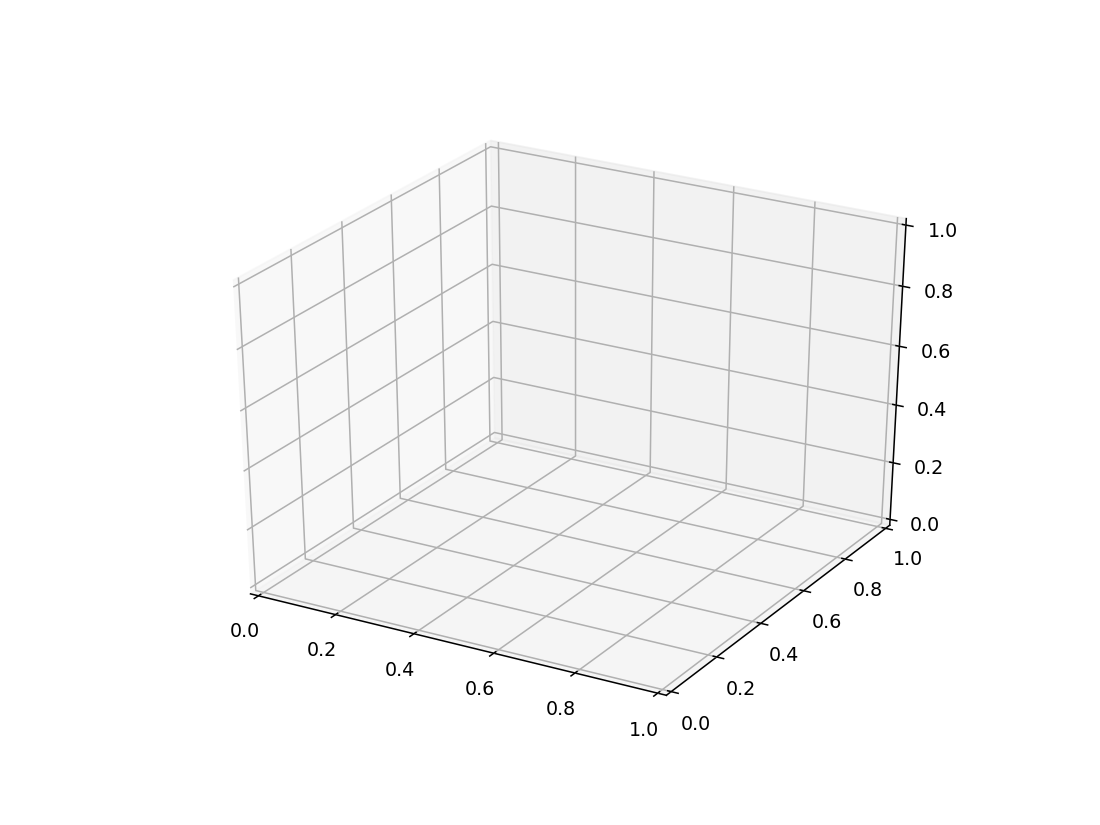

NameError: name 'predictions' is not defined

In [85]:
fig = plt.figure(3, (8,6))
ax = fig.add_subplot(1, 1, 1, projection='3d')
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
colors = ['blue', 'red', 'green', 'purple', 'gold', 'black', 'cyan', 'yellow', 'peru', 'lightblue']

for label in labels:
    '''
    0: bolt on table
    1: bolt assembled
    2: bolt in jig'''
    indices = np.nonzero(predictions == label)
    samples = x_test[indices,:].squeeze()
    if samples.ndim ==1:
        x_points = samples[0]
        y_points = samples[1]
        z_points = samples[2]
    else:
        x_points = samples[:,0]
        y_points = samples[:,1]
        z_points = samples[:,2]
    ax.scatter3D(x_points,z_points, y_points, c = colors[label], label='{}'.format(labels[label]))
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_ylim([-0.8,0.8])
    ax.set_zlabel('Z')
    plt.title('Bolt')
    plt.legend(loc = 'best',bbox_to_anchor=(1.05, 1))

# Next step: try ssp encoding

## Generate more data

In [23]:
%matplotlib notebook

import pickle
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from matplotlib import pyplot as plt

with open('../states_model/models_bolt_10', 'rb') as f:
    models = pickle.load(f)

n_samples = 1000
samples_bolt = []
x_train_gen = []
y_train_gen = []
for model in models:
    x_train_gen.append(np.random.multivariate_normal(model[0][:3] , model[1][:3,:3] , n_samples))
    y_train_gen += [model[2]] * n_samples 

x_train_gen = torch.FloatTensor(x_train_gen).view(-1, 3)
y_train_gen = torch.LongTensor(y_train_gen).view(-1,1)
print(x_train_gen.shape, y_train_gen.shape)

torch.Size([10000, 3]) torch.Size([10000, 1])


## Encode to ssp

In [120]:
import sys
sys.path.append("..")
from hrr import *
def ssp_encode(data, C, coord_only = True):
    # C is the cleanup memory that contains some concepts needed 
    n = data.shape[0] # number of datapoints
    m = np.zeros((n, C.dim))
    for i in range(n):
        x = data[i, 0].numpy()
        y = data[i, 1].numpy()
        z = data[i, 2].numpy()
        X = C.get('X')
        Y = C.get('Y')
        Z = C.get('Z')

        x_ssp = np.fft.ifft(np.fft.fft(X)**x).real
        y_ssp = np.fft.ifft(np.fft.fft(Y)**y).real
        z_ssp = np.fft.ifft(np.fft.fft(Z)**z).real

        if coord_only == True:
            m[i,:] = bind(bind(x_ssp, y_ssp), z_ssp)
        else:
            pass
    return m

In [39]:
import numpy as np
import nengo.spa as spa

def power(s, e):
    x = np.fft.ifft(np.fft.fft(s.v) ** e).real
    return spa.SemanticPointer(data=x)

def make_good_unitary(D, eps=1e-3, rng=np.random):
    a = rng.rand((D - 1) // 2)
    sign = rng.choice((-1, +1), len(a))
    phi = sign * np.pi * (eps + a * (1 - 2 * eps))
    assert np.all(np.abs(phi) >= np.pi * eps)
    assert np.all(np.abs(phi) <= np.pi * (1 - eps))

    fv = np.zeros(D, dtype='complex64')
    fv[0] = 1
    fv[1:(D + 1) // 2] = np.cos(phi) + 1j * np.sin(phi)
    fv[-1:D // 2:-1] = np.conj(fv[1:(D + 1) // 2])
    if D % 2 == 0:
        fv[D // 2] = 1

    assert np.allclose(np.abs(fv), 1)
    v = np.fft.ifft(fv)
    # assert np.allclose(v.imag, 0, atol=1e-5)
    v = v.real
    assert np.allclose(np.fft.fft(v), fv)
    assert np.allclose(np.linalg.norm(v), 1)
    return spa.SemanticPointer(v)

def encode_point(x, y, z, x_axis_sp, y_axis_sp, z_axis_sp):

    return power(x_axis_sp, x) * power(y_axis_sp, y) * power(z_axis_sp, z)

def encode_dataset(data, x_axis_sp, y_axis_sp, z_axis_sp):
    n = data.shape[0]
    dim = len(x_axis_sp.v)
    result = np.zeros((n, dim))
    for i in range(n):
        x = data[i][0].item()
        y = data[i][2].item()
        z = data[i][1].item()
        point_encoded = encode_point(x, y, z, x_axis_sp, y_axis_sp, z_axis_sp)
        result[i, :] = point_encoded.v
    return result
        
dim = 256
x_axis_sp = make_good_unitary(dim)
y_axis_sp = make_good_unitary(dim)
z_axis_sp = make_good_unitary(dim)

x_train_ssp = encode_dataset(x_train, x_axis_sp, y_axis_sp, z_axis_sp)

In [88]:
x_train_ssp.shape

(50, 256)

In [40]:
y_train.shape

torch.Size([50, 1])

## Create dataset

In [41]:
from torch.utils.data import Dataset, DataLoader

class Mydata(Dataset):
    
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __getitem__(self, ind):
        return self.x[ind], self.y[ind]
    
    def __len__(self):
        return len(self.x)

data = Mydata(torch.FloatTensor(x_train_ssp), y_train)

## Batch data

In [42]:
train_loader = DataLoader(data, batch_size = 32, shuffle = True)

## Structure of sspNet

In [43]:
class sspNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, output_dim)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x


## Define train

In [106]:
def train(dataloader, net, criterion, USE_GPU = True):
    for i, data in enumerate(dataloader):
        x, y = data
        if USE_GPU:
            x = x.cuda()
            y = y.cuda()
            net = net.cuda()
        net.zero_grad()
        output = net(x)
        loss = criterion(output, y.flatten())
        loss.backward()
        optimizer.step()
        return loss

def validate(x_val, y_val, net, criterion):
    val_loss = 0
    n = x_val.shape[0]
    d = x_val.shape[1]
    with torch.no_grad():
        for i in range(n):
            x = x_val[i].view(-1, d)
            y = torch.unsqueeze(y_val[i], 0)
            output = net(x)
            val_loss += criterion(output, y)    
        val_loss = val_loss / n
    return val_loss            

In [107]:
x_val_ssp = encode_dataset(x_val, x_axis_sp, y_axis_sp, z_axis_sp)

## Train

<IPython.core.display.Javascript object>


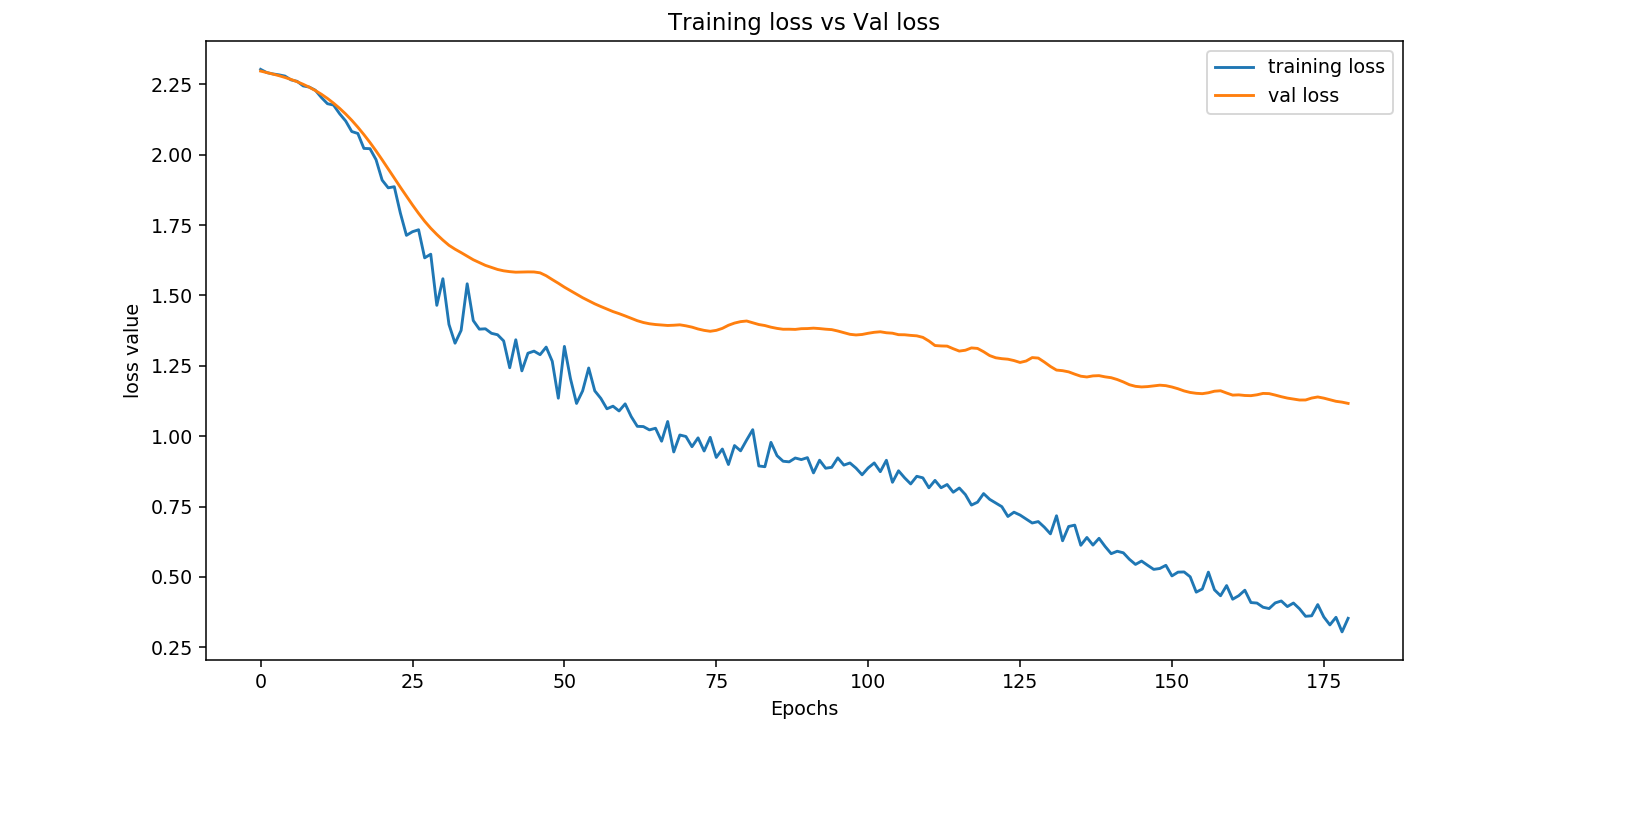

Epoch: 0 Loss: 2.303370237350464
Epoch: 1 Loss: 2.2920982837677
Epoch: 2 Loss: 2.287228584289551
Epoch: 3 Loss: 2.2839901447296143
Epoch: 4 Loss: 2.2796032428741455
Epoch: 5 Loss: 2.2661619186401367
Epoch: 6 Loss: 2.260911703109741
Epoch: 7 Loss: 2.2446978092193604
Epoch: 8 Loss: 2.2405166625976562
Epoch: 9 Loss: 2.2292635440826416
Epoch: 10 Loss: 2.2035884857177734
Epoch: 11 Loss: 2.181377410888672
Epoch: 12 Loss: 2.1766467094421387
Epoch: 13 Loss: 2.1458349227905273
Epoch: 14 Loss: 2.119961738586426
Epoch: 15 Loss: 2.082585334777832
Epoch: 16 Loss: 2.0756702423095703
Epoch: 17 Loss: 2.022575855255127
Epoch: 18 Loss: 2.0215723514556885
Epoch: 19 Loss: 1.9823867082595825
Epoch: 20 Loss: 1.9099524021148682
Epoch: 21 Loss: 1.8825563192367554
Epoch: 22 Loss: 1.886452317237854
Epoch: 23 Loss: 1.7928991317749023
Epoch: 24 Loss: 1.713710904121399
Epoch: 25 Loss: 1.7266420125961304
Epoch: 26 Loss: 1.7335014343261719
Epoch: 27 Loss: 1.633760929107666
Epoch: 28 Loss: 1.64670991897583
Epoch: 29 

In [110]:
import torch.optim as optim

output_dim = 10
epoches = 180
net_ssp = sspNet(dim, output_dim)
optimizer = optim.Adam(net_ssp.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

fig = plt.figure(5, figsize=(12,6))
plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
ax = fig.add_subplot(1,1,1)
val_loss_ssp_list = []
train_loss_ssp_list = []
for e in range(epoches):
    train_loss = train(train_loader, net_ssp.train(), criterion)
    train_loss_ssp_list.append(train_loss)
    val_loss = validate(torch.FloatTensor(x_val_ssp).cuda(), y_val.cuda(), net_ssp.eval(), criterion)
    val_loss_ssp_list.append(val_loss)
    ax.clear()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('loss value')
    ax.set_title('Training loss vs Val loss')
    ax.plot(train_loss_ssp_list, label='training loss')
    ax.plot(val_loss_ssp_list, label='val loss')
    ax.legend(loc='upper right')
    fig.canvas.draw()
    print("Epoch: {} Loss: {}".format(e, train_loss))


In [104]:
x_val_ssp

(100, 256)

# Test

## Define Test

In [46]:
def predict(x, net):
    with torch.no_grad():
        output = net(x)
        return torch.argmax(output)

def test(x_test, y_test, net, USE_GPU = True):
    n = x_test.shape[0]
    predictions = torch.zeros(n).long()
    if USE_GPU:
        x_test = x_test.cuda()
        net = net.cuda()
    with torch.no_grad():
        for i in range(n):
            prediction = predict(x_test[i,:], net)
            predictions[i] = prediction
        print(predictions.shape)
    accuracy = int(sum(predictions.detach() == y_test)) / n 
    return predictions, accuracy

In [111]:
n_test = 1000
accuracy = 0
for i in range(n_test):
    variance_coefficient = 5
    n_samples = 10
    samples_bolt = []
    x_test = []
    y_test = []
    for model in models:
        x_test.append(np.random.multivariate_normal(model[0][:3] , model[1][:3,:3] * variance_coefficient , n_samples))
        y_test += [model[2]] * n_samples 

    x_test = torch.FloatTensor(x_test).view(-1, 3)
    y_test = torch.FloatTensor(y_test)
    
    x_test_ssp = encode_dataset(x_test, x_axis_sp, y_axis_sp, z_axis_sp)
    a, b = test(torch.FloatTensor(x_test_ssp), y_test, net_ssp)
    accuracy += b
print(accuracy / n_test)

0.8613700000000022


In [74]:
n_samples = 10
x_test = []
y_test = []
c = 5

for model in models:
    x_test.append(np.random.multivariate_normal(model[0][:3] , model[1][:3,:3] * c , n_samples))
    y_test += [model[2]] * n_samples 

x_test = torch.FloatTensor(x_test).view(-1, 3)
y_test = torch.LongTensor(y_test)

x_test_ssp = encode_dataset(x_test, x_axis_sp, y_axis_sp, z_axis_sp)
print(x_test_ssp.shape)

(100, 256)


# Note:

- SSP does not work so far
- Get better code though
- Use dataloader and dataset for batch and more data
- TODO fix test function above

In [17]:
import numpy as np
import nengo.spa as spa

def power(s, e):
    x = np.fft.ifft(np.fft.fft(s.v) ** e).real
    return spa.SemanticPointer(data=x)

def make_good_unitary(D, eps=1e-3, rng=np.random):
    a = rng.rand((D - 1) // 2)
    sign = rng.choice((-1, +1), len(a))
    phi = sign * np.pi * (eps + a * (1 - 2 * eps))
    assert np.all(np.abs(phi) >= np.pi * eps)
    assert np.all(np.abs(phi) <= np.pi * (1 - eps))

    fv = np.zeros(D, dtype='complex64')
    fv[0] = 1
    fv[1:(D + 1) // 2] = np.cos(phi) + 1j * np.sin(phi)
    fv[-1:D // 2:-1] = np.conj(fv[1:(D + 1) // 2])
    if D % 2 == 0:
        fv[D // 2] = 1

    assert np.allclose(np.abs(fv), 1)
    v = np.fft.ifft(fv)
    # assert np.allclose(v.imag, 0, atol=1e-5)
    v = v.real
    assert np.allclose(np.fft.fft(v), fv)
    assert np.allclose(np.linalg.norm(v), 1)
    return spa.SemanticPointer(v)

def encode_point(x, y, x_axis_sp, y_axis_sp):

    return power(x_axis_sp, x) * power(y_axis_sp, y)

In [18]:
x = make_good_unitary(128)